This file contains the off-line augmentation and the split of the dataset.
The entire procedure was done this way to save time (so computation resources) during the training.

It's important to note that this dataset had been previously cleared of outliers images, basically with the following slicing operations `X = X[:1800]`
and `y = y[:1800]`, after noticing the last 1800 were essentially mixups between a blood cell and Shrek or Rick Astley (at that time we had not yet given up) and even with different labels!

In [ ]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras.utils import to_categorical
from keras import applications as pretrained
!pip install keras_cv
import keras_cv

import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

TEXT_LABELS = ['Basophil',               # 0
               'Eosinophil',             # 1
               'Erythroblast',           # 2
               'Immature granulocytes',  # 3
               'Lymphocyte',             # 4
               'Monocyte',               # 5
               'Neutrophil',             # 6
               'Platelet']               # 7

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import logging

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import random

seed = 42

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

import os
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

BASE_DIR = '/kaggle/input/hw1-dataset-2'
DATASET_FILENAME = os.path.join(BASE_DIR, 'dataset.npz')

# ⏳ Load Data

In [ ]:
data = np.load(DATASET_FILENAME)
print("Keys: ", data.keys())
X = data["images"]
y = data["labels"]
print("Data shape: ", X.shape)
print("Label shape: ", y.shape)

X, y = shuffle(X, y, random_state=seed)

Keys:  KeysView(NpzFile '/kaggle/input/hw1-dataset-2/dataset.npz' with keys: images, labels)
Data shape:  (11959, 96, 96, 3)
Label shape:  (11959, 1)


## 🔎 Inspect Data

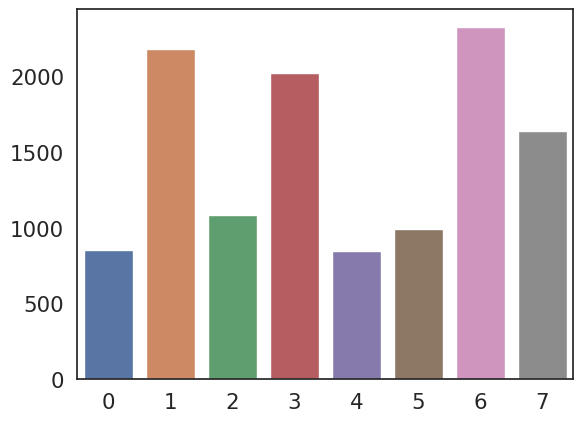

In [ ]:
lbl, cnt = np.unique(y, return_counts=True)
sns.barplot(x=lbl, y=cnt)
plt.show()

In [ ]:
def take_of_class(images, labels, n=4, targets=[0,1,2,3,4,5,6,7]):
    X = []

    for target_label in targets:
        target_indices = np.where(labels == target_label)[0]
        X.append(images[target_indices[:n]])

    return X, targets

def plot_samples(images, labels, categories):
    num_labels = len(labels)

    for i, label in enumerate(labels):
        title = f"{label}: {categories[label]}"
        num_images = images[i].shape[0]
        plt.figure(figsize=(6, (num_images+3)//4*2)).suptitle(title, fontsize=18)
        for j, img in enumerate(images[i]):
            plt.subplot((num_images+3)//4, 4, j+1)
            plt.imshow(img.astype("uint8"))
            plt.axis("off")
        plt.show()

def plot_all(images, title):
    num_images = images.shape[0]
    plt.figure(figsize=(6, (num_images+3)//4*2)).suptitle(title)
    for i in range(num_images):
        plt.subplot((num_images+3)//4, 4, i+1)
        plt.imshow(images[i].astype("uint8"))
        plt.axis("off")
    plt.show()

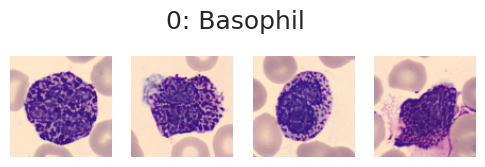

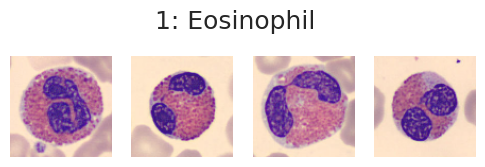

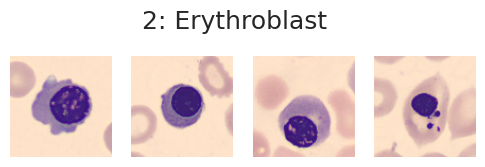

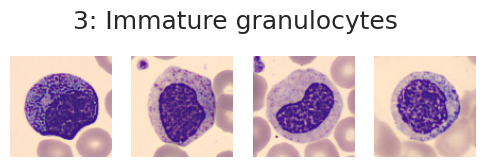

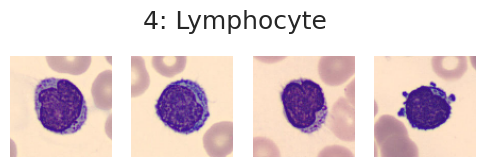

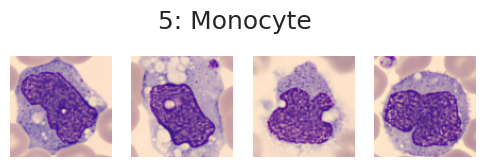

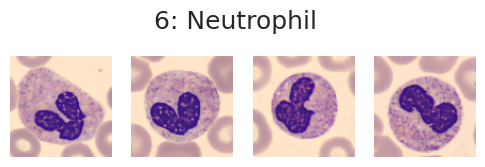

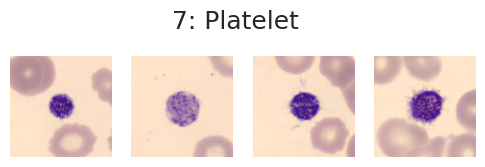

In [ ]:
img_sample, lbl_sample = take_of_class(X, y, n=4)
plot_samples(img_sample, lbl_sample, TEXT_LABELS)

# 🔄 Balance Dataset

In [ ]:
def random_over_sample(images, labels, seed=seed):
    ros = RandomOverSampler(sampling_strategy='auto', random_state=seed)
    n, h, w, c = images.shape
    images = images.reshape((n, h*w*c))
    images, labels = ros.fit_resample(images, labels)
    n = images.shape[0]
    images = images.reshape((n, h, w, c))
    images, labels = shuffle(images, labels, random_state=seed)
    return images, labels

def smote_over_sample(images, labels, seed=seed):
    smote = SMOTE(sampling_strategy='auto', random_state=seed)
    n, h, w, c = images.shape
    images = images.reshape((n, h*w*c))
    images, labels = smote.fit_resample(images, labels)
    n = images.shape[0]
    images = images.reshape((n, h, w, c))
    images, labels = shuffle(images, labels, random_state=seed)
    return images, labels

In [ ]:
X_random, y_random = random_over_sample(X, y)
X_smote, y_smote = smote_over_sample(X, y)

In [ ]:
def print_summary(X, y):
    lbl, cnt = np.unique(y, return_counts=True)
    sns.barplot(x=lbl, y=cnt)
    plt.show()

    print(cnt)
    img_sample, lbl_sample = take_of_class(X, y)
    plot_samples(img_sample, lbl_sample, TEXT_LABELS)

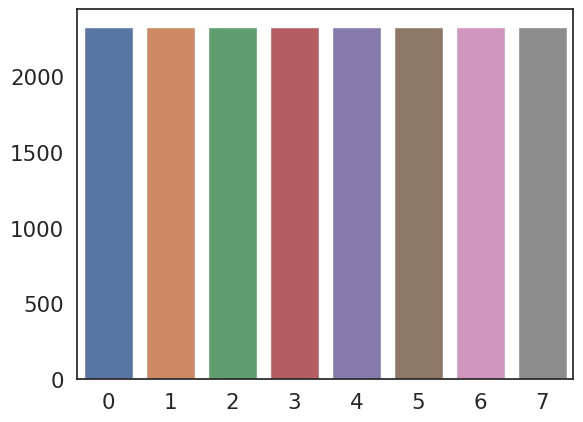

[2330 2330 2330 2330 2330 2330 2330 2330]


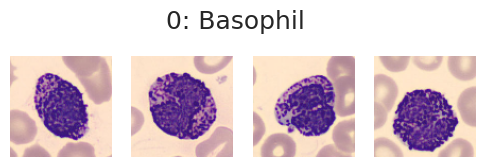

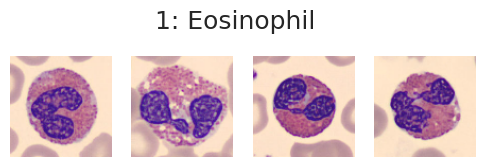

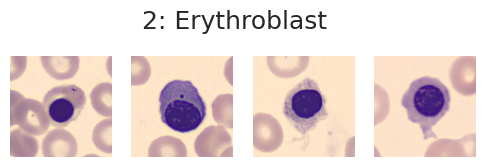

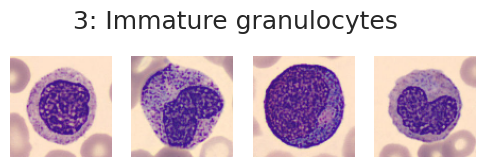

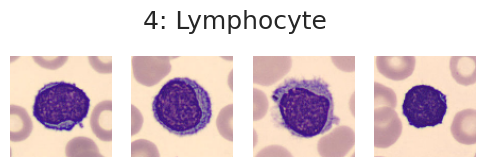

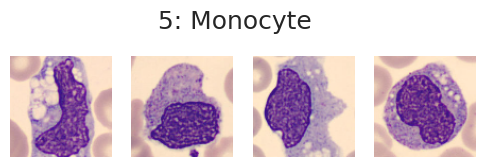

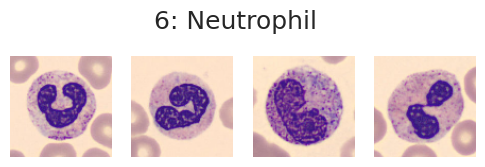

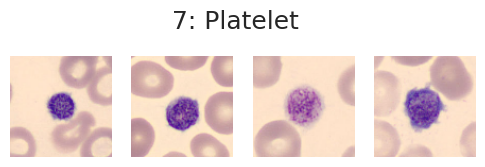

In [ ]:
print_summary(X_random, y_random)

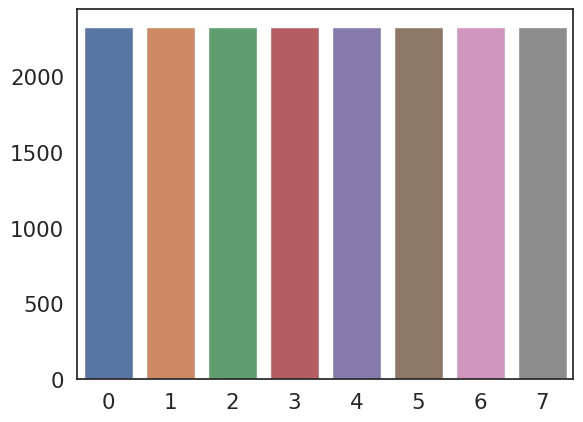

[2330 2330 2330 2330 2330 2330 2330 2330]


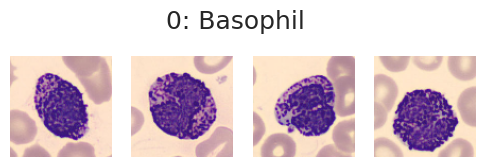

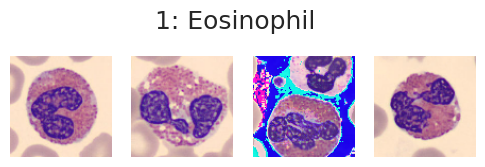

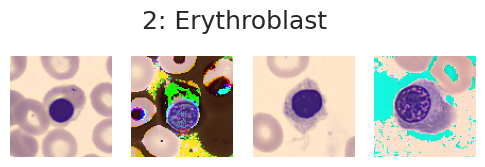

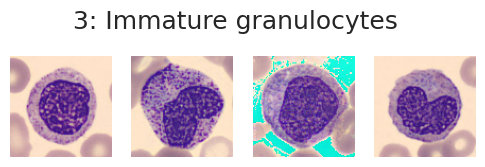

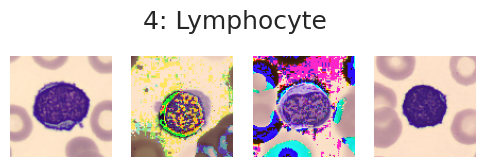

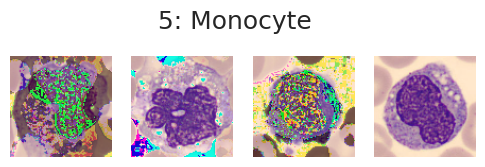

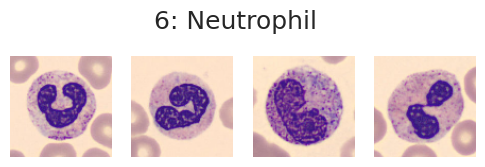

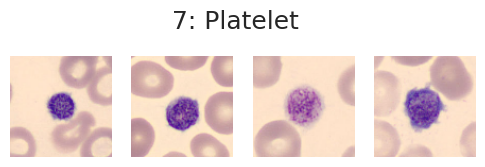

In [ ]:
print_summary(X_smote, y_smote)

Given the incredibly noisy images coming from SMOTE (k-nearest neighbors criteria does not work well with images), we decided to use the "synthetic" data generated by the RandomOverSampler utility. \
I mean, no guarantees that e.g. the third-nearest neighbor of an erythroblast  is itself an erythroblast.

# Split datasets

In [ ]:
X, y = X_random, y_random

test_size = 0.10
val_size = 0.10/(1.0-test_size)

# Split data into train-valid and test sets
X, X_test, y, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=y)

# Further split data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=seed, test_size=val_size, stratify=y)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_valid.shape)
print("Validation Label Shape:", y_valid.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (14911, 96, 96, 3)
Training Label Shape: (14911,)
Validation Data Shape: (1865, 96, 96, 3)
Validation Label Shape: (1865,)
Test Data Shape: (1864, 96, 96, 3)
Test Label Shape: (1864,)


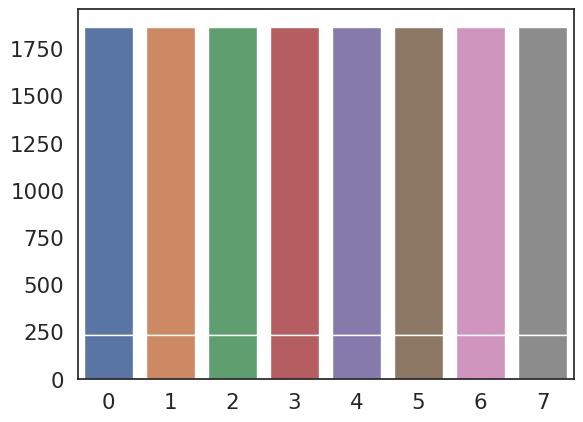

In [ ]:
val_train, cnt_train = np.unique(y_train, return_counts=True)
val_test, cnt_test = np.unique(y_test, return_counts=True)
val_val, cnt_val = np.unique(y_valid, return_counts=True)

sns.barplot(x=val_train, y=cnt_train)
sns.barplot(x=val_val, y=cnt_val)
sns.barplot(x=val_test, y=cnt_test)
plt.show()

In [ ]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_valid.shape)
print("Validation Label Shape:", y_valid.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (14911, 96, 96, 3)
Training Label Shape: (14911, 8)
Validation Data Shape: (1865, 96, 96, 3)
Validation Label Shape: (1865, 8)
Test Data Shape: (1864, 96, 96, 3)
Test Label Shape: (1864, 8)


 # 💪 Image augmentation

In [ ]:
#Add WGN to dataset points
def add_white_gaussian_noise(image, stddev=1):
    noise = np.random.normal(loc=0, scale=stddev, size=image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255)

    return noisy_image.astype(np.uint8)

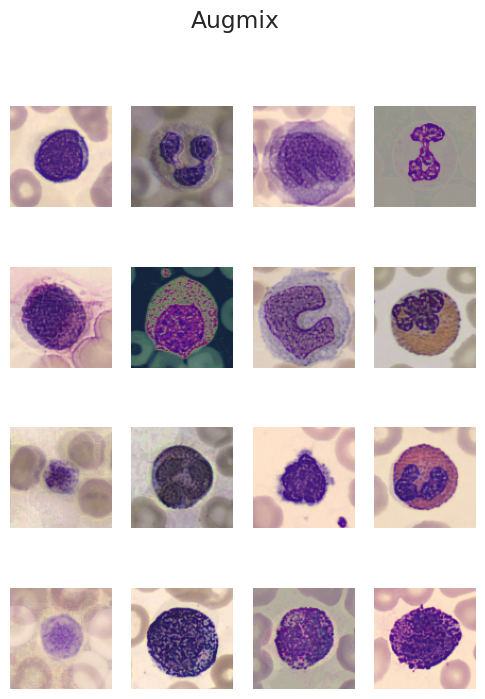

In [ ]:
augmix = keras_cv.layers.AugMix(
    value_range=(0, 255),
    severity=0.5,
    num_chains=3,
    chain_depth=[1, 4],
    alpha=0.8,
    seed=seed
)

X_augmix = np.copy(X_train)
y_augmix = np.copy(y_train)
X_augmix, y_augmix = shuffle(X_augmix, y_augmix, random_state=seed)
augmix_ds = {'images': tf.convert_to_tensor(X_augmix), 'labels': tf.convert_to_tensor(y_augmix)}
augmix_ds = augmix(augmix_ds)
X_augmix = augmix_ds['images'].numpy()
X_augmix = np.clip(X_augmix, 0, 255).astype(np.uint8)
y_augmix = augmix_ds['labels'].numpy()

plot_all(X_augmix[:16], "Augmix")

## 📢 Augment validation data

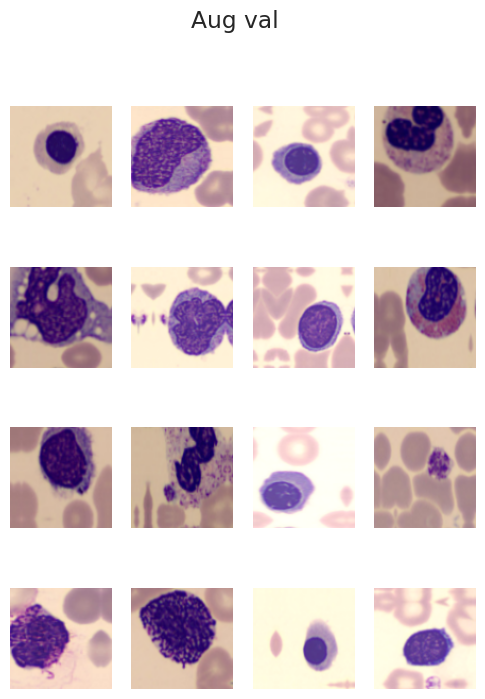

In [ ]:
valid_aug = tfk.Sequential([
    tfkl.RandomBrightness(factor=0.2, value_range=(0, 255), seed=seed),
    tfkl.RandomFlip(seed=seed),
    tfkl.RandomRotation(factor=0.3, seed=seed),
    tfkl.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=seed),
    tfkl.RandomZoom(height_factor=0.2, width_factor=0.2, seed=seed)
])

X_aug_val = valid_aug(X_valid)
X_aug_val = np.clip(X_aug_val, 0, 255).astype(np.uint8)

plot_all(X_aug_val[:16], "Aug val")

We also managed to "augment" even the test set by making its images noisy

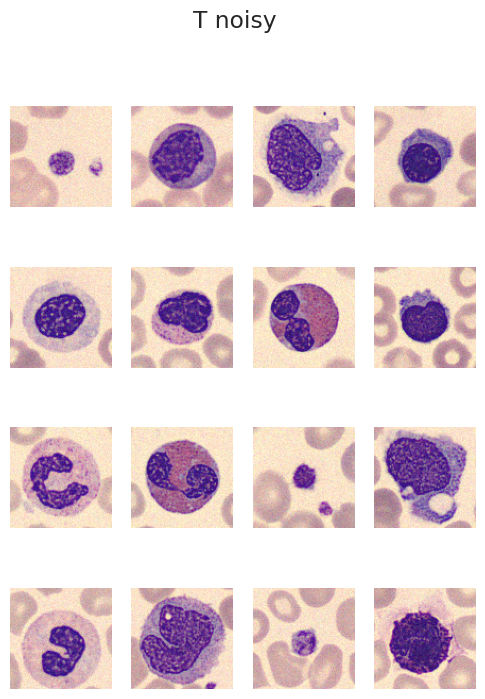

In [ ]:
X_test_noisy = np.copy(X_test)
for i, image in enumerate(X_test_noisy):
    X_test_noisy[i] = add_white_gaussian_noise(image, stddev=10)

plot_all(X_test_noisy[:16], 'T noisy')

# 💾 Save

In [ ]:
np.savez_compressed('train_set', images=X_augmix, labels=y_augmix)
np.savez_compressed('valid_set', images=X_aug_val, labels=y_valid)
np.savez_compressed('test_set', images=X_test, labels=y_test)

In [ ]:
np.savez_compressed('test_set_noisy', images=X_test_noisy, labels=y_test)